In [3]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
from math import sqrt
from matplotlib import pyplot as plt
import xgboost as xgb
%matplotlib inline

In [7]:
cnx = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [30]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [31]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,183978.0,91989.500000,53110.018250,1.0,45995.25,91989.5,137983.75,183978.0
player_fifa_api_id,183978.0,165671.524291,53851.094769,2.0,155798.00,183488.0,199848.00,234141.0
player_api_id,183978.0,135900.617324,136927.840510,2625.0,34763.00,77741.0,191080.00,750584.0
overall_rating,183142.0,68.600015,7.041139,33.0,64.00,69.0,73.00,94.0
potential,183142.0,73.460353,6.592271,39.0,69.00,74.0,78.00,97.0
crossing,183142.0,55.086883,17.242135,1.0,45.00,59.0,68.00,95.0
finishing,183142.0,49.921078,19.038705,1.0,34.00,53.0,65.00,97.0
heading_accuracy,183142.0,57.266023,16.488905,1.0,49.00,60.0,68.00,98.0
short_passing,183142.0,62.429672,14.194068,3.0,57.00,65.0,72.00,97.0
volleys,181265.0,49.468436,18.256618,1.0,35.00,52.0,64.00,93.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C64A95C400>,
      dtype=object)

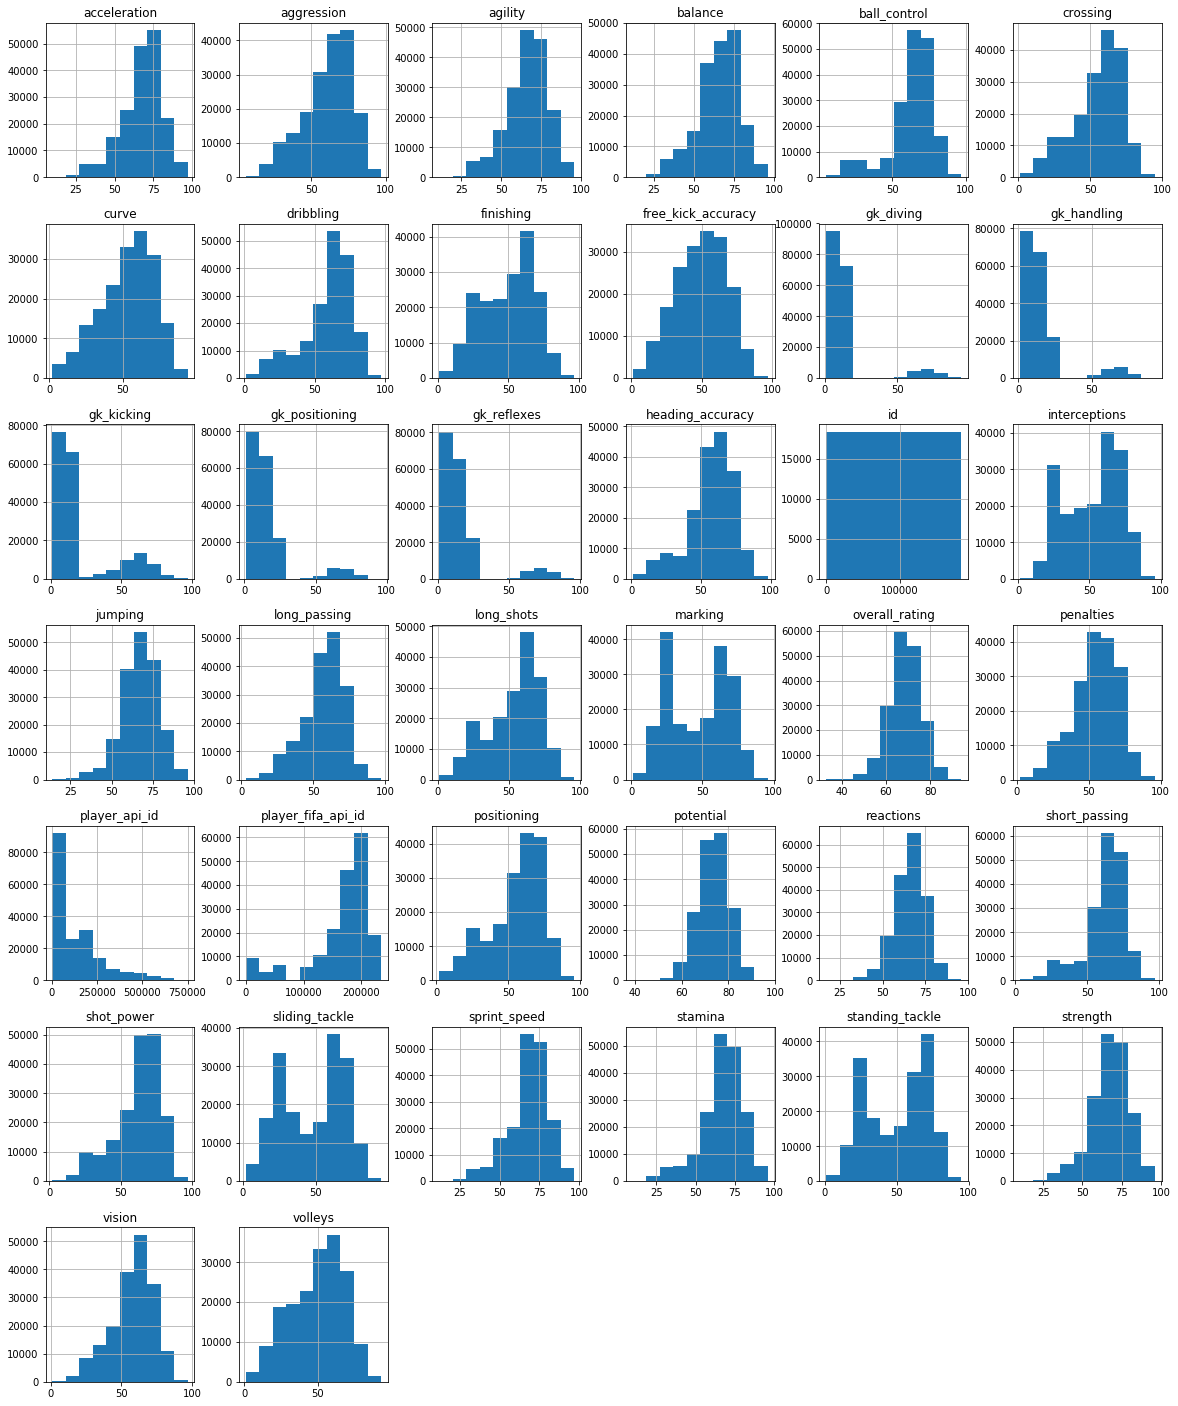

In [32]:
df.hist(figsize=(20,25))

In [33]:
df.isnull().sum(axis=0)

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [34]:
df.preferred_foot.unique()

array(['right', 'left', None], dtype=object)

In [35]:
df.attacking_work_rate.unique()

array(['medium', 'high', None, 'low', 'None', 'le', 'norm', 'stoc', 'y'],
      dtype=object)

In [36]:
df.defensive_work_rate.unique()

Wall time: 64 ms


array(['medium', 'high', 'low', '_0', None, '5', 'ean', 'o', '1', 'ormal',
       '7', '2', '8', '4', 'tocky', '0', '3', '6', '9', 'es'],
      dtype=object)

In [8]:
rows_with_null=df.shape[0]
df=df.dropna()
trm=rows_with_null-df.shape[0]
print('total rows removed {}'.format(trm))

total rows removed 3624


In [9]:
preferred_foot_num = pd.factorize(df.preferred_foot)
attacking_work_rate_num = pd.factorize(df.attacking_work_rate)
defensive_work_rate = pd.factorize(df.defensive_work_rate)

In [10]:
df.preferred_foot=preferred_foot_num[0]
df.attacking_work_rate = attacking_work_rate_num[0]
df.defensive_work_rate = defensive_work_rate[0]

In [11]:
df.corr().sort_values(['overall_rating'])['overall_rating']

player_api_id         -0.328315
player_fifa_api_id    -0.278703
id                    -0.003738
preferred_foot         0.001417
gk_handling            0.006717
gk_reflexes            0.007804
gk_positioning         0.008029
defensive_work_rate    0.023312
gk_diving              0.027675
gk_kicking             0.028799
attacking_work_rate    0.069407
sliding_tackle         0.128054
marking                0.132185
balance                0.160211
standing_tackle        0.163986
agility                0.239963
acceleration           0.243998
interceptions          0.249094
sprint_speed           0.253048
jumping                0.258978
heading_accuracy       0.313324
strength               0.315684
aggression             0.322782
stamina                0.325606
finishing              0.330079
free_kick_accuracy     0.349800
dribbling              0.354191
crossing               0.357320
curve                  0.357566
volleys                0.361739
positioning            0.368978
long_sho

In [12]:
df2=df[['heading_accuracy','strength','aggression','stamina','finishing','free_kick_accuracy','dribbling','crossing',
       'curve','volleys','positioning','long_shots','penalties','shot_power','vision','long_passing','ball_control','short_passing','potential','reactions','overall_rating']].copy()

In [13]:
df2.head()

,heading_accuracy,strength,aggression,stamina,finishing,free_kick_accuracy,dribbling,crossing,curve,volleys,...,long_shots,penalties,shot_power,vision,long_passing,ball_control,short_passing,potential,reactions,overall_rating
0,71.0,76.0,71.0,54.0,44.0,39.0,51.0,49.0,45.0,44.0,...,35.0,48.0,55.0,54.0,64.0,49.0,61.0,71.0,47.0,67.0
1,71.0,76.0,71.0,54.0,44.0,39.0,51.0,49.0,45.0,44.0,...,35.0,48.0,55.0,54.0,64.0,49.0,61.0,71.0,47.0,67.0
2,71.0,76.0,63.0,54.0,44.0,39.0,51.0,49.0,45.0,44.0,...,35.0,48.0,55.0,54.0,64.0,49.0,61.0,66.0,47.0,62.0
3,70.0,76.0,62.0,54.0,43.0,38.0,50.0,48.0,44.0,43.0,...,34.0,47.0,54.0,53.0,63.0,48.0,60.0,65.0,46.0,61.0
4,70.0,76.0,62.0,54.0,43.0,38.0,50.0,48.0,44.0,43.0,...,34.0,47.0,54.0,53.0,63.0,48.0,60.0,65.0,46.0,61.0


In [14]:
X = np.asarray(df2[['heading_accuracy','strength','aggression','stamina','finishing','free_kick_accuracy','dribbling','crossing',
                    'curve','volleys','positioning','long_shots','penalties','shot_power','vision','long_passing','ball_control','short_passing','potential','reactions']])
Y = np.asarray(df2.overall_rating)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25)

In [79]:
Lr=LinearRegression()
Lr.fit(X_train,Y_train)
y_pred=Lr.predict(X_test)
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, y_pred))
print('Variance score: %.2f' % r2_score(Y_test, y_pred))

Mean squared error: 10.77
Variance score: 0.78


In [83]:
dtregr = DecisionTreeRegressor(random_state=0,min_samples_split=8)
dtregr.fit(X_train, Y_train)
y_pred = dtregr.predict(X_test)
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, y_pred))
print('Variance score: %.2f' % r2_score(Y_test, y_pred))

Mean squared error: 3.09
Variance score: 0.94


In [87]:
rtr=RandomForestRegressor(max_features=2, min_samples_split=5, n_estimators=50, min_samples_leaf=2)
rtr.fit(X_train, Y_train)
y_pred =rtr.predict(X_test)
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, y_pred))
print('Variance score: %.2f' % r2_score(Y_test, y_pred))

Mean squared error: 1.69
Variance score: 0.97


In [20]:
xgbr=xgb.XGBRegressor(min_child_weight=11,gamma=0.5,subsample=0.8,colsample_bytree=0.6,max_depth=65)
xgbr.fit(X_train, Y_train)
y_pred =xgbr.predict(X_test)
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, y_pred))
print('Variance score: %.2f' % r2_score(Y_test, y_pred))

Mean squared error: 1.12
Variance score: 0.98
